In [1]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_validate, StratifiedKFold, StratifiedShuffleSplit, GroupKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

pclass: Status sócio-econômico
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

In [2]:
df = pd.read_csv('train.csv', sep=',')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Antes de realizar a análise exploratória, iremos realizar um *LabelEncoder* da coluna "Sex", porém de forma manual com replace.

In [3]:
df['Sex'].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

Feminino será 1

Masculino será 2

In [4]:
df['Sex'] = df['Sex'].replace({'female': 1, 'male': 2})
df.head()

C:\Users\DIOGO-PC\AppData\Local\Temp\ipykernel_16688\4270772836.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Sex'] = df['Sex'].replace({'female': 1, 'male': 2})


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",2,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",2,35.0,0,0,373450,8.0500,NaN,S


### Análise exploratória

**Explicação sobre o que representam os Quartis**

1° Quartil (25%):
- Representa o **valor abaixo do qual 25%** dos dados estão abaixo, por exemplo, a coluna **Age (idade)** é 20 (arredondado), ou seja, **25% dos passageiros tem menos de 20 anos**.

2° Quartil (50%):
- Representa o **valor abaixo do qual 50%** dos dados estão abaixo. A coluna *Age* é 28, ou seja, **50% dos passageiros tem idade inferior a 28 anos**, assim como, **50% dos passageiros tem idade superior a 28 anos**.
- Normalmente, o 2° Quartil (Q2) também pode ser a **mediana**.

3° Quartil (75%):
- Representa o **valor abaixo do qual 75%** dos dados estão abaixo. A coluna *Age* é 38, ou seja, **75% dos passageiros tem idade inferior a 38 anos**, assim como, **25% dos passageiros tem idade superior a 38 anos**.

**Para que servem?**

Os quartis ajudam a resumir e entender a distribuição dos dados sem precisar olhar todos os valores, identificando valores baixos, médios e altos. Na estátistica e análise de dados, são usados também para **detectar outliers** (valores extremos).

**Como são detectados os outliers?**

Se um dado está **muito abaixo** do 1° Quartil (Q1 - 25%) ou **muito acima** do 3° Quartil (Q3 - 75%), pode ser um valor atípico.

**Explicação sobre desvio padrão**

O **desvio padrão** é uma medida da **dispersão** dos dados **em torno da média**. Ele indica o quão espalhados os valores estão em relação à média. Um desvio padrão alto significa que os dados estão mais dispersos (os valores estão distantes da média), enquanto um desvio padrão baixo significa que estão mais próximos da média.

In [5]:
df.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,1.647587,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,1.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,2.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,2.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,2.000000,80.000000,8.000000,6.000000,512.329200


**Mediana**

O 2° Quartil (Q2) também pode ser considerada como a **mediana**, pois é o valor central de um array ordenado.

- Caso o número de elementos for **ímpar**, a **mediana é o valor central**.
- Caso o número de elementor for **par**, a **mediana é a média dos dois valores centrais**.

In [6]:
# Para exemplificar, exibe a mediana do valor central.
# É possível observar que tem o mesmo valor do Q2 (50%)
df['Age'].median()

np.float64(28.0)

In [7]:
df.info()

# Age -> substituir dados nulos pela média ou mediana baseado na pclass (status sócio-econômico)

# Embarked -> Já que são poucos dados nulos, creio que não terá problema desconsiderá-los

# Cabin -> A identificação da cabine seria um dado interessante para determinar se um passageiro poderia sobreviver ou não[...]
# [...] Porém, já que temos muitos dados nulos, talvez não deveriamos considerar esta coluna (?)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(6), object(4)
memory usage: 83.7+ KB


Podemos criar algumas hipóteses e validar sua veracidade, como por exemplo, pessoas de classes mais altas (status sócio-econômico) tiveram mais probabilidade de sobrevivência?

Primeiramente, iremos verificar qual o percentual de pessoas na 1° classe que sobreviveram.

In [8]:
df_pclass1 = df.query('Pclass == 1')
df_pclass1_survived = df_pclass1.query('Survived == 1')

print("Pessoas na 1° classe que sobreviveram:", len(df_pclass1_survived))
print("Total de passageiros na 1° classe:", len(df_pclass1))
print("Sobreviveram: ", round((len(df_pclass1_survived) * 100) / len(df_pclass1)), '%')

Pessoas na 1° classe que sobreviveram: 136
Total de passageiros na 1° classe: 216
Sobreviveram:  63 %


Em seguida, iremos verificar o percentual de pessoas em outras classes (2° e 3°) que sobreviveram.

In [9]:
df_pclass = df.query('Pclass != 1')
df_pclass_survived = df_pclass1.query('Survived == 1')

print("Pessoas nas outras classes que sobreviveram:", len(df_pclass_survived))
print("Total de passageiros nas outras classes:", len(df_pclass))
print("Sobreviveram: ", round((len(df_pclass_survived) * 100) / len(df_pclass)), '%')

Pessoas nas outras classes que sobreviveram: 136
Total de passageiros nas outras classes: 675
Sobreviveram:  20 %


A partir da análise, infelizmente é possível afirmar que pessoas da 1° classe tinham mais probabilidade de sobreviver que pessoas da 2° ou 3° classe.

Vamos analisar quantas pessoas de cada um dos 3 pontos de embarque sobreviveram.

In [10]:
df_embarked_grouped = df.groupby('Embarked')
df_embarked_grouped.size() # Conta quantos itens tem em cada grupo

Embarked
C    168
Q     77
S    644
dtype: int64

In [11]:
# Quantidade de pessoas que sobreviveram de cada ponto de embarque
df_embarked_grouped['Survived'].sum()

Embarked
C     93
Q     30
S    217
Name: Survived, dtype: int64

Sobreviveram mais mulheres ou homens?

In [12]:
woman = df.query('Sex == 1')
man = df.query('Sex == 2')

print('Total mulheres', len(woman))
print('Mulheres sobreviventes', woman['Survived'].sum(), '\n')
print('Total homens', len(man))
print('Homens sobreviventes', man['Survived'].sum())

Total mulheres 314
Mulheres sobreviventes 233 

Total homens 577
Homens sobreviventes 109


Todas as crianças sobreviveram?

In [13]:
df_children = df.query('Age < 14')

print('Quantidade de crianças a bordo:', len(df_children))
print('Quantidade de crianças sobreviventes:', df_children['Survived'].sum())
print('Percentual de crianças sobreviventes:', round((df_children['Survived'].sum() * 100) / len(df_children)), '%')

Quantidade de crianças a bordo: 71
Quantidade de crianças sobreviventes: 42
Percentual de crianças sobreviventes: 59 %


Quantidade de crianças por classe.

In [14]:
df_children['Pclass'].value_counts()

Pclass
3    49
2    18
1     4
Name: count, dtype: int64

Quantas crianças de cada classe sobreviveram?

A função *agg* aplica funções ao mesmo tempo.
- Sum adquire o total de sobreviventes.
- Count adquire o total de crianças na classe.

In [15]:
df_children_grouped = df_children.groupby('Pclass') # Crianças agrupadas pela classe
summary = df_children_grouped['Survived'].agg(['sum', 'count'])
summary['Taxa de sobrevivência (%)'] = round(summary['sum'] / summary['count'] * 100, 2) # Total de sobreviventes / Total de crianças * 100
summary = summary.rename(columns={'sum': 'Sobreviventes', 'count': 'Total de crianças'})

summary

,Sobreviventes,Total de crianças,Taxa de sobrevivência (%)
Pclass,,,
1,3,4,75.00
2,18,18,100.00
3,21,49,42.86


Agora vamos analisar como os dados estão distribuidos com um histograma.

array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Sex'}>, <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>],
       [<Axes: title={'center': 'Parch'}>,
        <Axes: title={'center': 'Fare'}>, <Axes: >]], dtype=object)

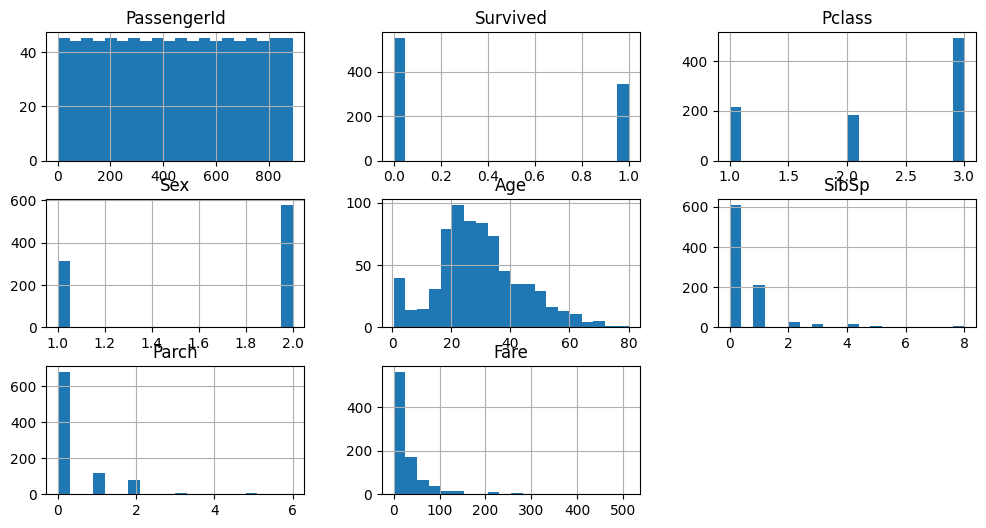

In [16]:
df.hist(figsize=(12,6), bins=20)

Também é interessante verificarmos se há alguns outliers a partir de um boxplot.

Temos outliers principalmente nas colunas *Age* (idade) e *Fare* (tarifa).

<Axes: >

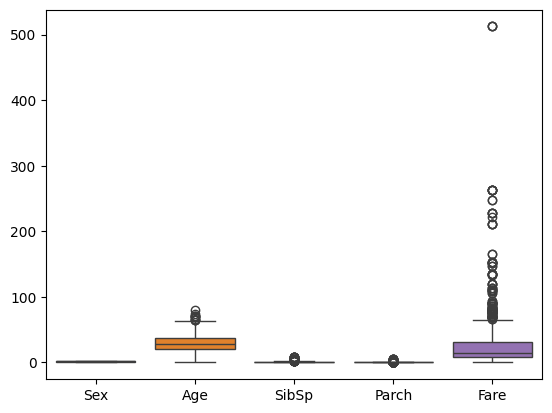

In [17]:
sns.boxplot(df.drop(['PassengerId', 'Survived', 'Pclass'], axis=1))

<Axes: >

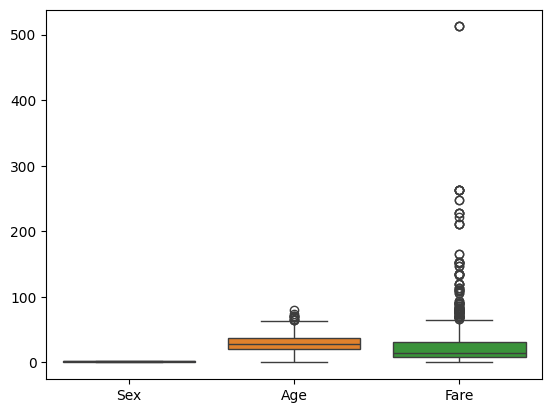

In [18]:
sns.boxplot(df.drop(['PassengerId', 'Survived', 'Pclass', 'SibSp', 'Parch'], axis=1))

Podemos também analisar a correlação para cada coluna, isto é, o quanto cada variável se relaciona entre si.

In [19]:
corr = df.select_dtypes(include=['number','float']).corr()

**Observações sobre as correlações**

É possível visualizar no mapa de calor abaixo (gráfico de correlação) que a variável **Pclass** tem uma correlação negativa com a variável alvo **Survived**, onde quando *Pclass* diminui, Survived aumenta (ou seja, é próximo de 1/true).

*Fare* (tarifa) tem uma correlação negativa com *Survived*, o que significa que a medida que a tarifa sobe, Survived é 1. Porém, não é uma correlação tão precisa quanto a variável categórica *Pclass*.

Inclusive, também há uma forte correlação negativa entre *Pclass* e *Fare*, significando que a medida que *Fare* sobe a *Pclass* é menor, em outras palavras, tarifas mais altas correspondem a classes mais caras (como por exemplo, a 1° classe).

Também há uma outra forte correlação negativa de *Survived* com *Sex*, indicando que a medida que Sex aumenta (1 feminino, 2 masculino) Survived diminui. O motivo disto é pelo fato de que mais mulheres sobreviveram do que homens.

**Dúvidas**
- Por mais que mulheres e crianças eram a prioridade para serem salvas no bote salva vidas a variável Age não tem uma correlação significativa com a variável alvo (Survived), que talvez poderia indicar quanto menor a idade, maior a chance de sobreviver. Porém, não é isto que os dados indicam.

<Axes: >

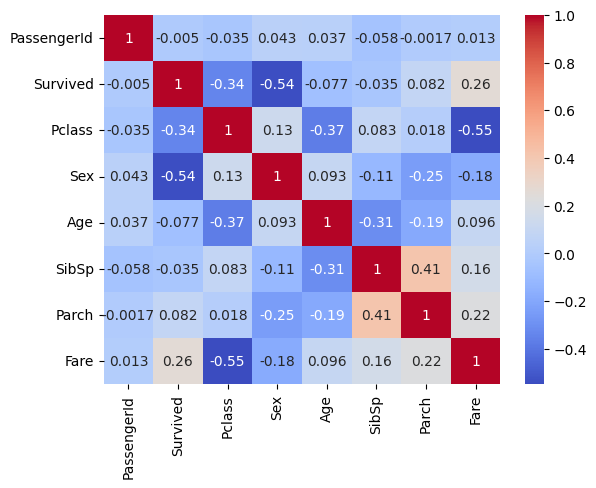

In [20]:
sns.heatmap(corr, annot=True, cmap='coolwarm')

### Pré-processamento dos dados

Antes de tudo, iremos substituir os valores nulos na coluna *Age* pela mediana de idade de passageiros em cada classe.

In [21]:
# Exibe os quartis de idade agrupados pelo n° da classe
df.groupby('Pclass')['Age'].quantile([0, .25, .50, .75, 1]).unstack() # unstack produz um dataframe como resultado

,0.00,0.25,0.50,0.75,1.00
Pclass,,,,,
1,0.92,27.0,37.0,49.0,80.0
2,0.67,23.0,29.0,36.0,70.0
3,0.42,18.0,24.0,32.0,74.0


O código abaixo calcula a mediana da idade para cada classe (Pclass).

A função *fillna* irá substituir os valores nulos pelo valor passado no parâmetro.

Agrupa os passageiros por classe, adquire a idade e, por fim, a função *transform('median')* retorna a mediana das idades dos passageiros agrupados pela classe, para cada linha do dataset.

In [22]:
df['Age'] = df['Age'].fillna(df.groupby('Pclass')['Age'].transform('median'))

In [23]:
# Iremos desconsiderar as colunas Cabin e Embarked, por isso não iremos preencher estes dados ausentes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(6), object(4)
memory usage: 83.7+ KB


Separando características dos rótulos.

In [24]:
X = df[['Age', 'Sex', 'Pclass', 'Fare']]
y = df['Survived']

In [25]:
SEED = 85

Separação em treino e teste (método HoldOut).

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

Padronização dos dados.

In [27]:
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

### Validação cruzada

In [28]:
def view_scores(results):
    test_mean = results['test_score'].mean()
    train_mean = results['train_score'].mean()

    print(f'Acurácia média treino: {train_mean*100:.2f}%')
    print(f'Acurácia média teste: {test_mean*100:.2f}%')
    print(f'Acurácia de teste entre {results["test_score"].min()*100:.2f}% e {results["test_score"].max()*100:.2f}%')

In [29]:
model_rt = RandomForestClassifier(max_depth=10, random_state=SEED)

rt_results = cross_validate(model_rt, X, y, cv=10, return_train_score=True)
view_scores(rt_results)

Acurácia média treino: 94.33%
Acurácia média teste: 83.40%
Acurácia de teste entre 76.40% e 92.13%


Necessário criar uma pipeline para o SVC pois necessita que a cada iteração da validação cruzada seja realizado uma nova padronização dos dados.

In [30]:
pipeline_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', SVC())
])

svc_results = cross_validate(pipeline_svc, X, y, cv=10, return_train_score=True)
view_scores(svc_results)

Acurácia média treino: 81.91%
Acurácia média teste: 81.25%
Acurácia de teste entre 76.40% e 87.64%
